# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Overview

Sparkify is a fictitious music company which provides free subscription to customers for a certain months. Post that the customer needs to renew his/her subscription. One who doesn't renew subscription is defined as a churn. This project aims to identify potential churned customers and features that might lead to churn. The underlined customer dataset is huge (12GB), so we would be using a subset of this dataset and Spark Machine Learning Models are to be used deal with Big Data. Exploratory Analysis would be done to find fruitful insights. Feature Engineering is to be used to create new additional features. Machine Learning models like Gradient Boost Classifier, Logistic Regression, Support Vector Machine and Random Forest are to be used to predict churn. Accuracy and F1-Score are the two metrics to be referred to select the best model. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
import datetime

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf

from pyspark.sql import functions as sF
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as f
from pyspark.sql import types as sT
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from functools import reduce

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [89]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [93]:
#Checking for missing user id in Spark
df.filter(df.userId == '').count()

8346

In [94]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')

In [95]:
df.filter(df.userId == '').count()

0

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [98]:
# Churn is a label for user who cancelled
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [102]:
#Drop duplicates in userId in spark
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [104]:
#Drop duplicates user status by gender in Spark
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



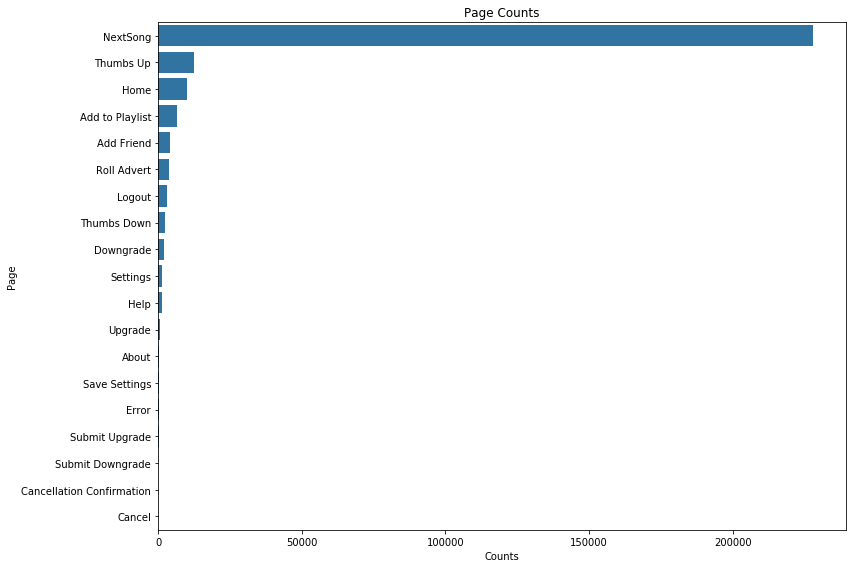

In [105]:
page_counts = pd.DataFrame(
    df.groupBy('page').count().collect(), columns=["page", "page_count"]
).sort_values(
    by='page_count', ascending=False
).reset_index()

# Instantiate plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot bar chart
base_color = sb.color_palette()[0]
sb.barplot(data=page_counts, y='page', x='page_count', ax=ax, color=base_color)

# Format chart
ax.set_ylabel("Page")
ax.set_xlabel("Counts")
ax.set_title("Page Counts")

plt.tight_layout()
plt.show()

Cancel and cancelation confirmation page counts are very low, which shows the data is highly skewed.

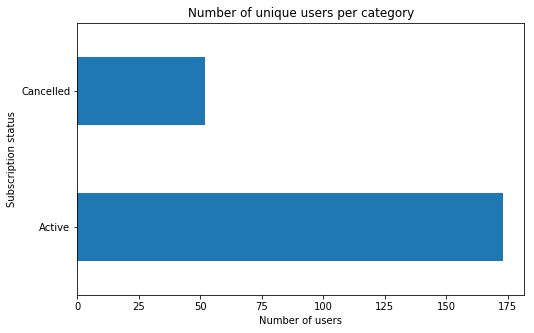

In [106]:
# Checking for Subscripion status in Pandas DataFrame
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = df_pandas.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(8,5), color = base_color,
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);

# Test    
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

Here we see that the number of active users are much higher as compared to the cancelled users.

Let's further deep-dive into this. Is there any distinction between active and cancelled users by gender?

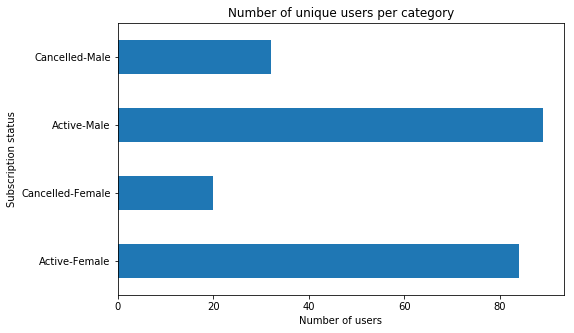

In [107]:
plot_frequency(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

We see that Male users are more active than female users. Even the cancelation rate of males are higher as compared to females.

Does Paid users have more cancellation as compared to free?

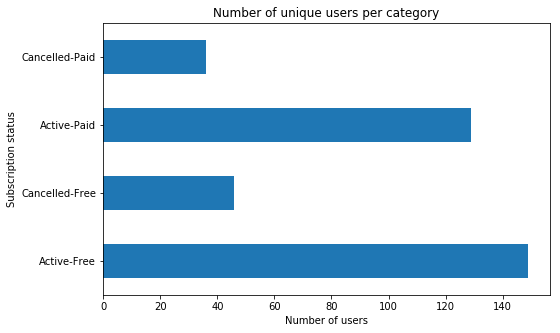

In [108]:
plot_frequency(['userId', 'level'], 
               ['level', 'churn'], 
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

The above plot shows that Free users remain more active than that of Paid, as well as they Cancel more than that of Paid.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In this section some more additional features needs to be created. Such as
1. Numeric Features: Average file length per session, Session duration, Session count, the total subscription days, number of thumbs-up, number of thumbs-down, number of friend invitations, number of listened-to files per session.
2. Categorical features: Gender and subscription level.    

## Time Analysis

In [109]:
# Convert timestamp
to_time_string = f.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('timestamp', f.to_timestamp(to_time_string(df['ts'])))

# Roll up to datestamp
df = df.withColumn('datestamp', df['timestamp'].cast('date'))

In [110]:
# Order dataframe by userId and timestamp
df = df.orderBy("userId", "ts")

# Function to convert milliseconds to days
days = lambda x: x * (1000 * 60 * 60 * 24)

# Flag cancellation within the next 3 days
churn_window = Window.partitionBy(df['userId']).orderBy(df['ts']).rangeBetween(0, days(3))

df = df.withColumn(
    "impending_churn", f.max(f.when(df.page == "Cancellation Confirmation", 1).otherwise(0)).over(churn_window)
)

In [111]:
# Create hour / day / month / year fields
df = df.withColumn("hour", f.hour("timestamp"))
df = df.withColumn("day", f.dayofmonth("timestamp"))
df = df.withColumn("month", f.month("timestamp"))
df = df.withColumn("year", f.year("timestamp"))

def days_since_reg(x, y):
    """
    Retrieve rounded number of days since registration
    """
    sec_diff = f.when(x > y, x - y).otherwise(0)    
    return f.round(sec_diff / (1000 * 60 * 60 * 24))


# Days since registration
df = df.withColumn(
    'days_since_reg', days_since_reg(df.ts, df.registration)
)

# Convert gender to binary column
df = df.withColumn('gender_male', f.when(df.gender == 'M', 1).otherwise(0))

# Convert subscription level to binary column
df = df.withColumn('paid_level', f.when(df.level == 'paid', 1).otherwise(0))

# List of unique page entries
pages = [row.page for row in df.select(df.page).dropDuplicates().collect()]

for page in pages:
    
    # Flag matching pages
    page_col = page.replace(" ", "")+"_page"
    df = df.withColumn(page_col, f.when(df.page == page, 1).otherwise(0))
    
    # for 1, 7, and 30 day intervals...
    for i in [1, 7, 30]:
                
        # Rolling window funciton for i days
        w = (Window().partitionBy(df['userId']).orderBy(df['ts']).rangeBetween(-days(i), 0))

        # Create column counting sum of page events in rolling window
        window_col = page.replace(" ", "") + "_last{}d".format(i)
        df = df.withColumn(window_col, f.sum(page_col).over(w))

### Create a dataframe for churn users

In [112]:
churn_users = df.select('userId', 'churn').dropDuplicates()

# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|   149|    0|
|    55|    0|
|   120|    0|
|   126|    0|
|   127|    0|
|200010|    0|
|   106|    1|
|100011|    1|
|   146|    0|
|    38|    0|
+------+-----+
only showing top 10 rows



### Creating dummy variable for gender

In [113]:
def create_dummy_df (col, dictionary):
    '''
    Create a dataframe to map a variable
    col: the column name
    dictionary: the mapping of from->to numeric values
    return a dataframe of 2 columns
    '''
    # To map M and F to numeric values, we first should map to string numbers (to avoid spark error)
    col_df = df.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    # Then convert the result to numeric value
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check
    print(col_df.printSchema(), col_df.show(3))
    return col_df


gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows

None None


### Creating dummy variable for Subscription level

In [114]:
level_df = create_dummy_df('level', {'paid':'1', 'free':'0'})

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
+------+-----+
only showing top 3 rows

None None


### Calculating Song length

In [115]:
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(10)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878
5,7,1.509289,1.737257
6,54,5.645595,6.724164
7,15,9.470389,6.159368
8,155,9.202745,6.528672
9,100014,3.134420,1.754365


### Calculating the Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades etc.

In [116]:
# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1

# the columns to be summed
pages_cols = user_page_distribution.columns[1:]

# Add a total column
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))

# Apply normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


### No. of songs per session

In [117]:
# number of changing songs
song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



### No. of artists the user fan

In [118]:
# Number of artists the user fans
artists_user_fans = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(3)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
+------+----------+
only showing top 3 rows



### Session duration

In [119]:
#session duration
session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [120]:
#mean and sd of session duration
session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
+------+-------------------+------------------+
only showing top 3 rows



### Session count per user

In [121]:
# 2-H Sessions count per user
num_sessions_user_df = df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



### User's subscription age

In [122]:
# 2-I The user's subscription age
def days_since_subscription(df, col_name='days_on'):
    # timestamp of users registration
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



### Free or Paid song percentages per user

In [123]:
paid_free_df = df.filter(df.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(10)

+------+------------------+-----------------+
|userId|      free_percent|     paid_percent|
+------+------------------+-----------------+
|200002| 22.48062015503876|77.51937984496125|
|100010|             100.0|              0.0|
|   125|             100.0|              0.0|
|     7|             100.0|              0.0|
|   124|               0.0|            100.0|
|    51|               0.0|            100.0|
|    54|15.452305526223162|84.54769447377683|
|    15|               0.0|            100.0|
|   155|12.317073170731707| 87.6829268292683|
|   132|1.4522821576763485|98.54771784232366|
+------+------------------+-----------------+
only showing top 10 rows



### Merging all the features

In [124]:
# the features to collect
user_features = [gender_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df, artists_user_fans, 
                   session_user_df, num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'paid_free_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                   'session_user_df', 'num_sessions_user_df', 'reg_df']

In [125]:
# Initialize the final_df
final_df = churn_users

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)

Preparing features of the gender_df dataframe; the new frame's dimensions is: 225 * 3
Preparing features of the paid_free_df dataframe; the new frame's dimensions is: 225 * 5
Preparing features of the song_length dataframe; the new frame's dimensions is: 225 * 7
Preparing features of the user_page_distribution dataframe; the new frame's dimensions is: 225 * 24
Preparing features of the song_user_df dataframe; the new frame's dimensions is: 225 * 26
Preparing features of the artists_user_fans dataframe; the new frame's dimensions is: 225 * 27
Preparing features of the session_user_df dataframe; the new frame's dimensions is: 225 * 29
Preparing features of the num_sessions_user_df dataframe; the new frame's dimensions is: 225 * 30
Preparing features of the reg_df dataframe; the new frame's dimensions is: 225 * 31


In [126]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- free_percent: double (nullable = true)
 |-- paid_percent: double (nullable = true)
 |-- mean_hours: double (nullable = false)
 |-- stdev_hours: double (nullable = false)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Submit Downgrade: double (nullable = true)
 |-- Submit Upgrade: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- mean

In [139]:
final_df.write.save('cleaned_dataset.CSV', format='csv', header=True)

In [3]:
final_df1 = spark.read.csv('cleaned_dataset.CSV', header = True)

In [4]:
final_df1.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- free_percent: string (nullable = true)
 |-- paid_percent: string (nullable = true)
 |-- mean_hours: string (nullable = true)
 |-- stdev_hours: string (nullable = true)
 |-- About: string (nullable = true)
 |-- Add Friend: string (nullable = true)
 |-- Add to Playlist: string (nullable = true)
 |-- Downgrade: string (nullable = true)
 |-- Error: string (nullable = true)
 |-- Help: string (nullable = true)
 |-- Home: string (nullable = true)
 |-- Logout: string (nullable = true)
 |-- NextSong: string (nullable = true)
 |-- Roll Advert: string (nullable = true)
 |-- Save Settings: string (nullable = true)
 |-- Settings: string (nullable = true)
 |-- Submit Downgrade: string (nullable = true)
 |-- Submit Upgrade: string (nullable = true)
 |-- Thumbs Down: string (nullable = true)
 |-- Thumbs Up: string (nullable = true)
 |-- Upgrade: string (nullable = true)
 |-- mean_

In [5]:
# Change the column names to strings without spaces
for col in final_df1.columns:
    final_df1 = final_df1.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(final_df1.columns)

['userId', 'churn', 'gender', 'free_percent', 'paid_percent', 'mean_hours', 'stdev_hours', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'num_aritst', 'mean_session_h', 'stdev_session_h', 'num_sessions', 'days_total_subscription']


In [6]:
# Convert all to numbers as the schema shows strings
# the first column (userId) would be integer
final_df1 = final_df1.withColumn('userId', final_df1.userId.cast(sT.IntegerType()))
# All columns from Churn to OS_* should be integer types
for col in final_df1.columns[1:12]:
    final_df1 = final_df1.withColumn(col, final_df1[col].cast(sT.IntegerType()))
# All other columns should be float
for col in final_df1.columns[12:]:
    final_df1 = final_df1.withColumn(col, final_df1[col].cast(sT.FloatType()))

final_df1.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- free_percent: integer (nullable = true)
 |-- paid_percent: integer (nullable = true)
 |-- mean_hours: integer (nullable = true)
 |-- stdev_hours: integer (nullable = true)
 |-- About: integer (nullable = true)
 |-- Add_Friend: integer (nullable = true)
 |-- Add_to_Playlist: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Error: integer (nullable = true)
 |-- Help: float (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll_Advert: float (nullable = true)
 |-- Save_Settings: float (nullable = true)
 |-- Settings: float (nullable = true)
 |-- Submit_Downgrade: float (nullable = true)
 |-- Submit_Upgrade: float (nullable = true)
 |-- Thumbs_Down: float (nullable = true)
 |-- Thumbs_Up: float (nullable = true)
 |-- Upgrade: float (nullable = true)
 |-- mean_

In [7]:
# Remove  nulls from anywhere replacing them by zeros
final_df1 = final_df1.na.fill(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [8]:
# The input features are all but the userId and the Churn
# The output is Churn only

# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=final_df1.columns[2:], outputCol='features')

# Apply the vectorization on the dataset
input_data = features_vector.transform(final_df1)
# input_data.show(1)

In [9]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [10]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [11]:
# train test split
train, rest = ml_data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

## Gradient Boost Classifier

In [133]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [135]:
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.7644186054202666]

In [137]:
results_gbt = cvModel_gbt.transform(validation)

In [138]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.7142857142857143
F-1 Score:0.6714285714285715


## Logistic Regression

In [12]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [13]:
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

[0.6815005292653724]

In [14]:
results_lr = cvModel_lr.transform(validation)

In [15]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.7916666666666666
F-1 Score:0.7423054587688733


## Support Vector Machine

In [16]:
# initialize classifier
svm = LinearSVC(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [17]:
cvModel_svm = crossval_svm.fit(train)
cvModel_svm.avgMetrics

[0.6914987736234883]

In [18]:
results_svm = cvModel_svm.transform(validation)

In [19]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.75
F-1 Score:0.6607142857142857


## Random Forest Classifier

In [33]:
# initialize classifier
rf = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [34]:
cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics

[0.7016250430518266]

In [35]:
results_rf = cvModel_rf.transform(validation)

In [36]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.75
F-1 Score:0.6607142857142857


From the above results we see that:
1. Gradient Boost Classifier shows an accuracy of 0.71 and F-1 Score of 0.61
2. Logistic Regression shows an accuracy of 0.79 and F-1 Score of 0.74
3. Support VectorMachine shows an accuracy of 0.75 and F-1 Score of 0.66
4. Random Forest shows an accuracy of 0.75 and F-1 Score of 0.66

Here we see Logistic Regression model out-performs other models in terms of accuracy and F-1 Score. So, we were selecting Logistic Regression as our best model. We will now use Grid-Search and Cross-validation techniques to fine tune our hyper parameters so that we can improve the performance of our model.

# Grid Search and Cross Validation

In [24]:
# initialize classifier
best = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(best.regParam,[0.01, 0.1]) \
    .addGrid(best.elasticNetParam,[0.0, 0.5]) \
    .addGrid(best.aggregationDepth,[2, 5]) \
    .build()

crossval_best = CrossValidator(estimator=best,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [25]:
cvModel_best =crossval_best.fit(train)
cvModel_best.avgMetrics

[0.6983459578265585,
 0.6983459578265585,
 0.7293653124660582,
 0.7293653124660582,
 0.6893174252212928,
 0.6893174252212928,
 0.6914761387852751,
 0.6914761387852751]

In [26]:
results_best = cvModel_best.transform(validation)

In [27]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Best Model: Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_best, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_best, {evaluator.metricName: "f1"})))

Best Model: Logistic Regression Metrics:
Accuracy: 0.8125
F-1 Score:0.7768518518518519


From the Grid-Search, we obtained an accuracy of 0.81 and F-1 Score of 0.78, which is much higher than our previous models. Now, it's important to identify the important variables which helps in determining the churn

In [30]:
def draw_features_contribution(fitted_model, x_labels, scale_to='full_range'):
    '''
    Draws a bar chart of features vs churn %
    fitted_model: the fitted model
    scale_to: the values will be scated to:
           'full_range' where the full absolute values are summed to 100.
           'maximum_range' where the maximum absolute extremes are scalled to 100.
           'none' the values are shown as is.
    '''
    cmx = fitted_model.bestModel.coefficientMatrix
    cmv = cmx.values
    # cmv.shape, len(final_df.columns[2:])
    
    # Define positive and negative values
    positives_v = np.array([x if x>=0 else 0 for x in cmv])
    negatives_v = np.array([x if x<=0 else 0 for x in cmv])    
    
    # Drawing by scalling the maximum range to  100
    if scale_to == 'full_range':
        rang = positives_v.sum()+ abs(negatives_v).sum()
    elif scale_to == 'maximum_range':
        rang = positives_v.max()+ abs(negatives_v).max()
    else:
        rang = 1.
        
    positives_v /= rang
    negatives_v /= rang
    positives_v *= 100.
    negatives_v *= 100.
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(x_labels, positives_v,color='r')
    ax.bar(x_labels, negatives_v, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('The user is most likely to churn (%)')
    ax.set_title('Contribution of each feature to the churn decission')
    ax.set_xticklabels(labels = final_df1.columns[2:], rotation='vertical');

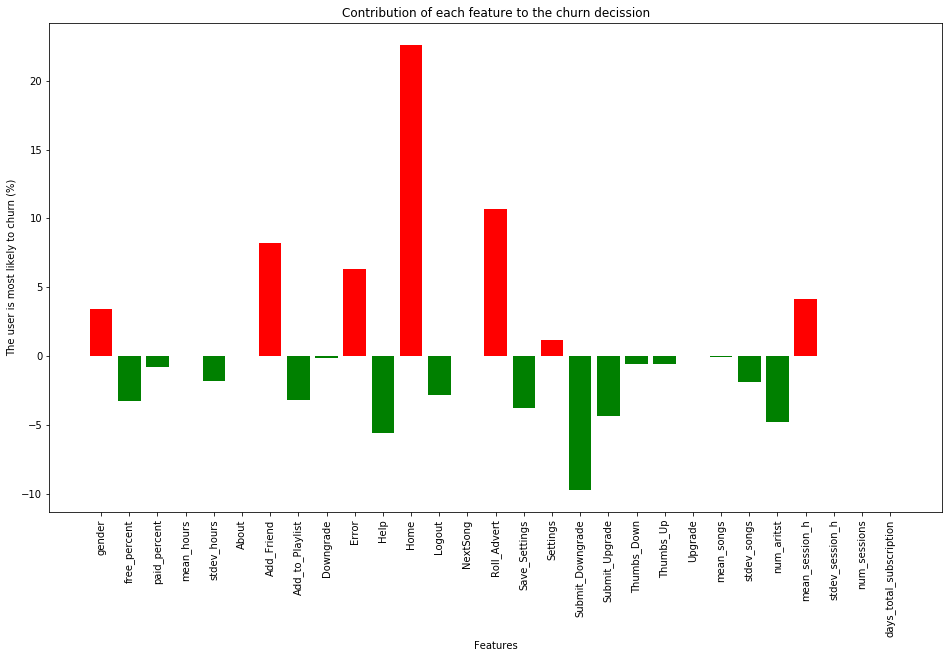

In [37]:
draw_features_contribution(cvModel_best, x_labels=final_df1.columns[2:])

Here we see that gender, add_friend, error, home, roll_advert, settings, mean_session_hr are key important features in determining churn. 

In the descriptive stats, we seen that there is a relationship between subscription status and gender, add friend identifies one who is more interested will definitely recommend to other users. Less the error better the user experience, better the home page better the experience. Settings also do play an important role in user experience. More time a user spends, better the experience.

## Conclusion
In this project, we aimed to predict the churn of customer. The customer dataset is huge (12 GB) so we used only a subset of the dataset, Big Data Tool Spark is used to deal with such a huge dataset. In the data exploration step, we removed duplicates in userid and missing userid. We also looked into the distribution of Subscription status across gender and payment status. In Feature Engineering we created derived fields like Average file length per session, Session duration, Session count, the total subscription days, number of thumbs-up, number of thumbs-down, number of friend invitations, number of listened-to files per session. We subsetted the data with 60% training and rest 40% into two equal parts: crossvalidation and test. We used Gradient Boost Classifier, Logistic Regression, Support Vector Machine and RandomForest to predict the churn of customer. Logistic Regression out-performed other models in terms of accuracy and F1-Score. So, we used Grid Search along with Gradient Descent to fine tune the hyper-parameters and obtained  an accuracy of 0.81 and F1-Score of 0.78. We also identified the variable of importance from the model like gender, add_friend, error, home, roll_advert, settings, mean_session_hr so that Sparkify can pay more attention to these features. Thus we were successful in predicting churn of customers.

## Next Steps
1. Working with the full 12GB dataset
2. Need to incorporate some additional features like platform the user is using (like Android/ iOS)
3. Trying with different combinations of hyper-parameters in the model

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.